In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import PIL
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

random_state = 22222

In [2]:
!ls data

happy-whale-and-dolphin  local_split_og


In [3]:
!ls data/happy-whale-and-dolphin/

sample_submission.csv  test_images  train.csv  train_images


In [4]:
full_train_df = pd.read_csv('data/happy-whale-and-dolphin/train.csv')

full_train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


In [5]:
full_train_df['species'].value_counts()

bottlenose_dolphin           9664
beluga                       7443
humpback_whale               7392
blue_whale                   4830
false_killer_whale           3326
dusky_dolphin                3139
spinner_dolphin              1700
melon_headed_whale           1689
minke_whale                  1608
killer_whale                 1493
fin_whale                    1324
gray_whale                   1123
bottlenose_dolpin            1117
kiler_whale                   962
southern_right_whale          866
spotted_dolphin               490
sei_whale                     428
short_finned_pilot_whale      367
common_dolphin                347
cuviers_beaked_whale          341
pilot_whale                   262
long_finned_pilot_whale       238
white_sided_dolphin           229
brydes_whale                  154
pantropic_spotted_dolphin     145
globis                        116
commersons_dolphin             90
pygmy_killer_whale             76
rough_toothed_dolphin          60
frasiers_dolph

Some of the species names are incorrect (e.g. "kiler_whale") or have duplicate entries (e.g. "globis" and "pilot_whale" for "short_finned_pilot_whale"), so we'll fix that here.

In [6]:
full_train_df['species'].replace({"globis": "pilot_whale",
                          "short_finned_pilot_whale": "pilot_whale",
                          "long_finned_pilot_whale": "pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

full_train_df['species'].value_counts()

bottlenose_dolphin           10781
beluga                        7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
pilot_whale                    983
southern_right_whale           866
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64

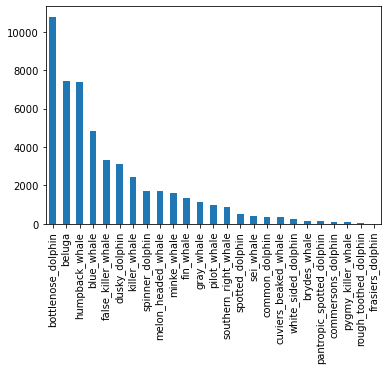

In [7]:
full_train_df['species'].value_counts().plot.bar();

# PUT SOME IMAGES AND STUFF HERE***

In [8]:
kaggle_data_dir = 'data/happy-whale-and-dolphin/train_images'

In [9]:
local_dataset_imgs_names = [file for file in os.listdir(kaggle_data_dir)]
local_dataset_imgs_names[0:10]

['00021adfb725ed.jpg',
 '000562241d384d.jpg',
 '0007c33415ce37.jpg',
 '0007d9bca26a99.jpg',
 '00087baf5cef7a.jpg',
 '000a8f2d5c316a.jpg',
 '000be9acf46619.jpg',
 '000bef247c7a42.jpg',
 '000c3d63069748.jpg',
 '000c476c11bad5.jpg']

In [10]:
print('There are', len(local_dataset_imgs_names), 'whale and dolphin images to be split.')

There are 51033 whale and dolphin images to be split.


# The train/val/test split

We'll do two sets of splits, one to create a dataset for training species recognition, and one for training individual recognition. The reason for this is that the necessary sizes of the val and test sets in the individual id recognition set are larger than we would ideally like them to be. This is because making sure that each individual ends up in the train set AND that the split is stratified requires about 6,000 photos in val and test, far more than is necessary. So the species split will be a more ideal 95/5 split, and the id split will be its own irregular thing.

### The species split is fairly straightforward.

In [36]:
train_val_df_sp, test_df_sp = train_test_split(full_train_df, test_size=.05, stratify=full_train_df['species'], random_state=random_state)

In [38]:
train_df_sp, val_df_sp = train_test_split(train_val_df_sp, test_size=.05, stratify=train_val_df_sp['species'], random_state=random_state)

### The individual id split is slightly more complicated.

There are some individuals for whom only one image exists. We want to make sure they end up in the train set because if we eventually submit our work to the Kaggle competition, we'll want to have trained on them. Unfortunately, merely setting stratify inside train_test_split won't work, because there would need to be at least two images, so first, we'll move those individuals to a special dataframe that we eventually merge with our train dataframe.

In [17]:
counts = full_train_df['individual_id'].value_counts()

single_ind_df = full_train_df[full_train_df['individual_id'].isin(counts[counts == 1].index)]
partial_full_df = full_train_df[~full_train_df['individual_id'].isin(counts[counts == 1].index)]

In [18]:
single_ind_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9258 entries, 0 to 51018
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          9258 non-null   object
 1   species        9258 non-null   object
 2   individual_id  9258 non-null   object
dtypes: object(3)
memory usage: 289.3+ KB


In [19]:
partial_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41775 entries, 1 to 51032
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          41775 non-null  object
 1   species        41775 non-null  object
 2   individual_id  41775 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [20]:
train_val_df_id, test_df_id = train_test_split(partial_full_df, test_size=.152, stratify=partial_full_df['individual_id'], random_state=random_state)

In [23]:
train_df_id_lite, val_df_id = train_test_split(train_val_df_id, test_size=.179, stratify=train_val_df_id['individual_id'], random_state=random_state)

In [31]:
train_df_id = pd.concat([single_ind_df, train_df_id_lite]).sort_index()

In [44]:
train_df_id.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [35]:
# Just to make sure we've done everything right
(pd.concat([train_df_id, val_df_id, test_df_id]).sort_index() == full_train_df).value_counts()

image  species  individual_id
True   True     True             51033
dtype: int64

In [16]:
train_imgs_names = list(train_df['image'].values)
val_imgs_names = list(val_df['image'].values)
test_imgs_names = list(test_df['image'].values)

Now we'll copy the images from kaggle's train folder into our new folder structure, according to the train/val/test split we just performed on the dataframe.

In [ ]:
local_split_dir = 'data/local_split'

train_folder = os.path.join(local_split_dir, 'train')
val_folder = os.path.join(local_split_dir, 'validation')
test_folder = os.path.join(local_split_dir, 'test')

Only run these next two cells during initial setup.

In [ ]:
# os.mkdir(local_split_dir)

# os.mkdir(train_folder)
# os.mkdir(val_folder)
# os.mkdir(test_folder)

In [ ]:
# # copy train images
# for image in train_imgs_names:
#     origin = os.path.join(kaggle_data_dir, image)
#     destination = os.path.join(train_folder, image)
#     shutil.copyfile(origin, destination)
    
# # copy val images
# for image in val_imgs_names:
#     origin = os.path.join(kaggle_data_dir, image)
#     destination = os.path.join(val_folder, image)
#     shutil.copyfile(origin, destination)
    
# # copy test images
# for image in test_imgs_names:
#     origin = os.path.join(kaggle_data_dir, image)
#     destination = os.path.join(test_folder, image)
#     shutil.copyfile(origin, destination)

In [ ]:
print('There are', len(os.listdir(train_folder)), 'images in the training set.')
print('There are', len(os.listdir(val_folder)), 'images in the validation set.')
print('There are', len(os.listdir(test_folder)), 'images in the test set.')